In [78]:
import pandas as pd
import sqlite3

# UniCat

In [62]:
VABB = pd.read_csv("data/cleaning/VABB_books_isbn_level.csv", index_col=0, dtype={"isbn":"str"})

In [63]:
con = sqlite3.connect("unicat_holdings.db")

In [64]:
df = pd.read_sql(
    """
    SELECT holding_count, work_id
    FROM (
        SELECT work_id, COUNT(DISTINCT location) holding_count
        FROM holding
        GROUP BY work_id
    )
    """,
    con,
)

In [65]:
isbn_search = pd.read_sql("""SELECT work_id, isbn FROM isbn_search""", con)

### create dataframe isbn - holding and add PR info

In [66]:
VABB_infogp = VABB.reset_index()[["isbn", "VABB_infogpstd"]].copy()

In [67]:
def add_infogp(dataframe, infogpdata, isbn_search):
    df_infogp = isbn_search.merge(infogpdata, on="isbn")
    df_infogp = pd.DataFrame(df_infogp.groupby("work_id").VABB_infogpstd.apply(";".join)).reset_index()
    df_infogp.VABB_infogpstd = df_infogp.VABB_infogpstd.str.split(";").copy()
    df_infogp["PR_status"] = ["PR" if "gp" in i else "PR" if "wos" in i else "nonPR" for i in df_infogp.VABB_infogpstd]
    df_infogp = df_infogp.drop(columns="VABB_infogpstd").copy()
    df = df_infogp.merge(dataframe, on="work_id")
    df = df.set_index("work_id")
    return df

In [68]:
df = add_infogp(df, VABB_infogp, isbn_search)

### Average scores PR vs nonPR

In [69]:
df.groupby("PR_status").describe()

holding_count                                              
                  count      mean       std  min  25%  50%  75%   max
PR_status                                                            
PR               9888.0  5.340514  4.072426  1.0  2.0  4.0  8.0  24.0
nonPR           15636.0  6.177475  4.879229  1.0  2.0  5.0  9.0  35.0

## Visualizing

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [71]:
font = {'size'   : 15}

matplotlib.rc('font', **font)

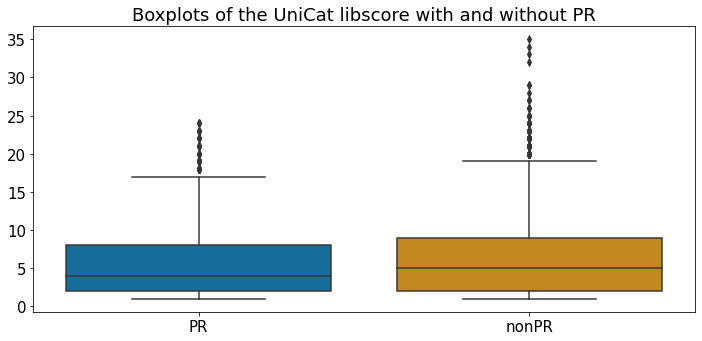

In [72]:
fig, ax = plt.subplots(figsize = (10,5))

sns.set_palette("colorblind")
sns.boxplot(x=df.PR_status,y=df.holding_count, ax=ax)

plt.ylabel("")
plt.xlabel("")
plt.title("Boxplots of the UniCat libscore with and without PR")

plt.tight_layout()

plt.savefig("plots/Comparison_PR_colorblind.png")

In [73]:
df = df.reset_index()
sizefreq = df.groupby(["holding_count","PR_status"]).count().reset_index().rename(columns={"work_id":"count"})

In [74]:
sizefreq.head(3)

,holding_count,PR_status,count
0,1,PR,1665
1,1,nonPR,3113
2,2,PR,1631


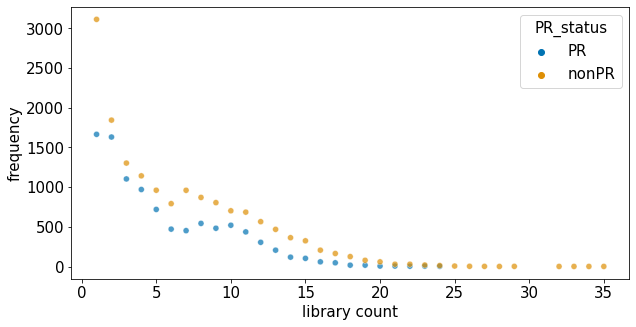

In [76]:
fig, ax = plt.subplots(figsize = (10,5))

sns.set_palette("colorblind")
sns.scatterplot(data=sizefreq, x="holding_count",y="count", hue="PR_status", alpha=0.7, ax=ax)

ax.set_ylabel("frequency")
ax.set_xlabel("library count")


plt.savefig("plots/UniCat_Comparison_PR_colorblind.png")

## Statistical test

In [31]:
import scipy.stats as stats

In order to test whether the means are the same or different, we perform a two-sample unpaired t-test.

null hypothesis: the means are equal
alternative hypothesis: the means are not equal

The test statistic has two assumptions:

1. Homogeneity (the variance can be compared through Levene's test)
2. Either both samples are large (>30) or they are both from a normal distribution

If there is no homogeneity, the Welch t-statistic should be relied on instead.

Raf's suggestion --> use a Mann-Whitney U-test because we cannot assume normality

In [32]:
sample1 = df[df.PR_status == "nonPR"].holding_count
sample2 = df[df.PR_status == "PR"].holding_count

stats.levene(sample1, sample2, center="median")

LeveneResult(statistic=355.8795223349058, pvalue=7.649825198528706e-79)

In [33]:
sample1.mean()

6.177475057559478

In [34]:
sample2.mean()

5.340513754045308

We cannot assume equality of variances.

In [35]:
U1,p = stats.mannwhitneyu(sample1,sample2)

In [36]:
'{:.40f}'.format(p)

'0.0000000000000000000031905326552238269522'

In [37]:
print(p)

3.190532655223827e-21


# Cultuurconnect

### Import data

In [38]:
con = sqlite3.connect("""cultuurconnect.db""")

In [40]:
holding = pd.read_sql("""SELECT w.work_id, COUNT(distinct library) holding_count
                        FROM holding h
                        JOIN works_frabl w ON h.frabl = w.frabl
                        GROUP BY work_id
                        """, con)

In [41]:
works_isbn = pd.read_sql("""SELECT isbn, work_id FROM works_isbn""", con)

### Cleaning

In [42]:
info = VABB.reset_index()[["isbn","VABB_infogpstd"]]

In [43]:
df = add_infogp(holding,info,works_isbn)

## average scores PR and nonPR

In [44]:
df.groupby("PR_status").describe()

holding_count                                                   
                  count       mean        std  min  25%  50%    75%    max
PR_status                                                                 
PR                981.0   7.589195  22.585471  1.0  1.0  2.0   5.00  312.0
nonPR            7064.0  16.772225  33.999260  1.0  2.0  4.0  14.25  426.0

### visualizing

In [45]:
df = df.reset_index()

In [46]:
sizefreq = df.groupby(["holding_count","PR_status"]).count().reset_index().rename(columns={"work_id":"count"})

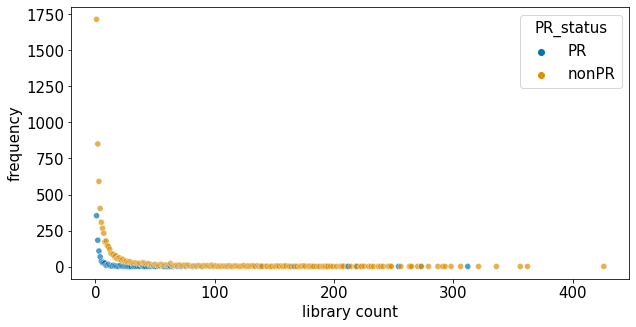

In [51]:
fig, ax = plt.subplots(figsize = (10,5))

sns.set_palette("colorblind")

sns.scatterplot(data=sizefreq, x="holding_count",y="count", hue="PR_status", alpha=0.7, ax=ax)

ax.set_ylabel("frequency")
ax.set_xlabel("library count")


plt.savefig("plots/Cultuurconnect_Comparison_PR_colorblind.png")

## Statistical test

In [52]:
sample1 = df[df.PR_status == "nonPR"].holding_count
sample2 = df[df.PR_status == "PR"].holding_count

stats.levene(sample1, sample2, center="median")

LeveneResult(statistic=61.70563651304788, pvalue=4.503817920480426e-15)

In [53]:
sample1.mean()

16.77222536806342

In [54]:
sample2.mean()

7.589194699286442

The Levene's test with a small p-value suggests that equality of variances cannot be assumed

In [55]:
U1,p = stats.mannwhitneyu(sample1,sample2)

In [56]:
print(p)

8.583281915362014e-41


## PR vs nonPR for entire VABB

In [57]:
VABB_infogp.VABB_infogpstd = VABB_infogp.VABB_infogpstd.fillna("").copy()

In [58]:
VABB_infogp["PR_status"] = ["PR" if "gp" in i else "PR" if "wos" in i else "nonPR" for i in VABB_infogp.VABB_infogpstd]

In [59]:
PR_VABB = pd.DataFrame(VABB_infogp.groupby("PR_status").isbn.count()).reset_index()

In [60]:
PR_VABB["percentage"] = PR_VABB.isbn/PR_VABB.isbn.sum()

In [61]:
PR_VABB

,PR_status,isbn,percentage
0,PR,16555,0.354945
1,nonPR,30086,0.645055
